In [1]:
import findspark
findspark.init("/home/raj/spark/")

In [2]:
from pyspark.ml.clustering import KMeans,BisectingKMeans
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
# Trains a k-means model.
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

def Bisect_Kmeans():
    
    

#creation of spark session
    spark = SparkSession \
        .builder \
        .appName("Python Spark ML example") \
        .getOrCreate()
# Loads data.
    dataset= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")




    dataset.toPandas()

#Creating the indexes.
#this model clusters points considering only 3 attributed age,sex and income
    workclass_stringIndexer = StringIndexer(inputCol="workclass", outputCol="workclass_indexed")
    si_model_workclass = workclass_stringIndexer.fit(dataset)
    education_stringIndexer = StringIndexer(inputCol="education", outputCol="education_indexed")
    si_model_education = education_stringIndexer.fit(dataset)
    occupation_stringIndexer = StringIndexer(inputCol="occupation", outputCol="occupation_indexed")
    si_model_occupation = occupation_stringIndexer.fit(dataset)
    sex_stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
    si_model_sex = sex_stringIndexer.fit(dataset)
    income_stringIndexer = StringIndexer(inputCol="income", outputCol="income_indexed")
    si_model_income = income_stringIndexer.fit(dataset)
    td = si_model_workclass.transform(si_model_education.transform(si_model_occupation.transform(si_model_sex.transform(si_model_income.transform(dataset)))))
    td.toPandas()


#feature_columns = ["age","workclass_indexed","fnlwgt","education_num","hours_per_week","sex_indexed","education_indexed","occupation_indexed","income_indexed"]
    feature_columns = ["age","sex_indexed","income_indexed"]
    feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    td_dataset_prepared = feature_assembler.transform(td)
    td_dataset_prepared.printSchema()
    td_dataset_prepared.toPandas()

#creating the model
    bkm = BisectingKMeans(k=2, minDivisibleClusterSize=1.0)
    model=bkm.fit(td_dataset_prepared)#the model is applied on the dataset

    centers = model.clusterCenters()
    print(centers)#prints the centers of the clusters-usully the euclidean centers.if we take n-attributes we get n-dimensions euclidean space

    summary = model.summary

    summary.k#prints the number of clusters

    return summary.cluster.show() #the first two points form the custer with centers 45.5,0,0.5 whereas the last three form the cluster with center as 28.67,0.67,0.33



In [3]:
Bisect_Kmeans()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- income_indexed: double (nullable = true)
 |-- sex_indexed: double (nullable = true)
 |-- occupation_indexed: double (nullable = true)
 |-- education_indexed: double (nullable = true)
 |-- workclass_indexed: double (nullable = true)
 |-- features: vector (nullable = true)

[array([28.69527897,  0.33476395,  0.14653587]), array([50.98903509,  0.28874269,  0.35964912])

In [4]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import DecisionTreeRegressor
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import StringIndexer
from pyspark.sql import SparkSession

def DecisionTree_Regressor():
    

    spark = SparkSession.builder.appName("DecisionTreeRegressionExample").getOrCreate()

 
    dataset = spark.read.format("csv").option("inferSchema","true").option("header","true").load("/home/raj/Downloads/notenook/adult2.csv")

#dataset.printSchema()
    #indexer converts categorical data into numerics 
    workclass_stringIndexer = StringIndexer(inputCol="workclass", outputCol="workclass_indexed")
    si_model_workclass = workclass_stringIndexer.fit(dataset)

    education_stringIndexer = StringIndexer(inputCol="education", outputCol="education_indexed")
    si_model_education = education_stringIndexer.fit(dataset)

    occupation_stringIndexer = StringIndexer(inputCol="occupation", outputCol="occupation_indexed")
    si_model_occupation = occupation_stringIndexer.fit(dataset)

    sex_stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
    si_model_sex = sex_stringIndexer.fit(dataset)

    income_stringIndexer = StringIndexer(inputCol="income", outputCol="income_indexed")
    si_model_income = income_stringIndexer.fit(dataset)

    td = si_model_workclass.transform(si_model_education.transform(si_model_occupation.transform(si_model_sex.transform(si_model_income.transform(dataset)))))

#convert to pandas dataframe
    td.toPandas()



    feature_columns = ["age","workclass_indexed","fnlwgt","education_num","hours_per_week","sex_indexed","education_indexed","occupation_indexed"]

    feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
    data = feature_assembler.transform(td)

    # Automatically identify categorical features, and index them.
    # We specify maxCategories so features with > 4 distinct values are treated as continuous.
    featureIndexer = VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(data)

    # Split the data into training and test sets (30% held out for testing)
    (trainingData, testData) = data.randomSplit([0.7, 0.3])
    print(featureIndexer)

    # Train a DecisionTree model.
    dt = DecisionTreeRegressor(featuresCol="indexedFeatures",labelCol="income_indexed")

    # Chain indexer and tree in a Pipeline
    pipeline = Pipeline(stages=[featureIndexer, dt])

    # Train model.  This also runs the indexer.
    model = pipeline.fit(trainingData)

    # Make predictions.
    predictions = model.transform(testData)

    # Select example rows to display.
    predictions.select("prediction", "income_indexed", "features").show(5)

    # Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
       labelCol="income_indexed", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)
    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    treeModel = model.stages[1]
    
    return rmse , treeModel


In [6]:
DecisionTree_Regressor()

VectorIndexer_40a591e2b36e921e36ca
+--------------------+--------------+--------------------+
|          prediction|income_indexed|            features|
+--------------------+--------------+--------------------+
|0.014675052410901468|           0.0|[17.0,3.0,47407.0...|
|0.014675052410901468|           0.0|[17.0,3.0,64785.0...|
|0.014675052410901468|           0.0|[17.0,3.0,80077.0...|
|0.014675052410901468|           0.0|[17.0,3.0,138507....|
|0.014675052410901468|           0.0|[17.0,3.0,202521....|
+--------------------+--------------+--------------------+
only showing top 5 rows

Root Mean Squared Error (RMSE) on test data = 0.389421


(0.38942095287931117,
 DecisionTreeRegressionModel (uid=DecisionTreeRegressor_4f129b6a4aa240dddc3e) of depth 5 with 61 nodes)

In [7]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import DecisionTreeClassifier

def Decision_tree_classifier():

    spark = SparkSession \
        .builder \
        .appName("Decision tree") \
        .getOrCreate()
	
#creating dataframe	
    ad_data= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")
    ad_data.createOrReplaceTempView("adult")
    dataset = spark.table("adult")
    cols = dataset.columns
#print cols

####### if you would like to check how the dataframe looks like and it's columns ######

#ad_data.createOrReplaceTempView("adult")
#dataset = spark.table("adult")
#cols = dataset.columns
#print cols

############# Columns ##################


    categoricalColumns = ["workclass"]
    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
        encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
     # onehotencoder will take n-1 distinct values and convert to vector
        stages += [stringIndexer, encoder]
#print stages


#
# Convert label into label indices using the StringIndexer
    label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")
    stages += [label_stringIdx]
# Transform all features into a vector using VectorAssembler
    numericCols = ["age","hours_per_week"]
    assemblerInputs = list(map(lambda c: c + "classVec", categoricalColumns)) + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

# Create a Pipeline.
    pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(dataset)
    dataset = pipelineModel.transform(dataset)

# Keep relevant columns
    selectedcols = ["label", "features"] + cols
    dataset = dataset.select(selectedcols)

# we can use print dataset
### Randomly split data into training and test sets. set seed for reproducibility
    (trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)
### so if we have 100 records then 70 will be in training and 30 will be in testing (approximately)


# Create initial Decision Tree Model
    dt = DecisionTreeClassifier(labelCol="label", featuresCol="features", maxDepth=3)

# Train model with Training Data
    dtModel = dt.fit(trainingData)

    print("numNodes = ", dtModel.numNodes) # total number of nodes from root to leaf with longest path
    print("depth = ", dtModel.depth)    #max depth of the nodes

# Make predictions on test data using the Transformer.transform() method.
    predictions = dtModel.transform(testData)

#print schema
    predictions.printSchema()


# View model's predictions and probabilities of each prediction class
#selecting the required columns
    selected = predictions.select("label", "prediction", "probability", "age","income")

#Printing the schema
    selected.printSchema()

#printing the predicted data
    selected.show(truncate=False)

# Evaluate model
    evaluator = BinaryClassificationEvaluator()

    print("evaluation")
    print(evaluator.evaluate(predictions))
    
    return evaluator.getMetricName()


In [8]:
Decision_tree_classifier()

numNodes =  15
depth =  3
root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- rawPrediction: vector (nullable = true)
 |-- probability: vector (nullable = true)
 |-- prediction: double (nullable = true)

root
 |-- label: double (nullable = true)
 |-- prediction: double (nullable = true)
 |-- probability: vector (nullable = true)
 |-- age: in

'areaUnderROC'

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import GBTClassifier
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorIndexer


def GBT_classifier():

    spark = SparkSession.builder.appName("Gbt_classifier").getOrCreate() 

# Load and parse the data file, converting it to a DataFrame.
    data = spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load("/home/raj/Downloads/notenook/adult2.csv")



    data.show()

    categoricalColumns = ["workclass", "occupation"]

    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#.fit(ad_data)
	#df_numeric = stringIndexer.transform(ad_data)
	#df_numeric.repartition(1).repartition(1).write.csv('indexer')
	#print df_numeric.select('workclass','workclassIndex').show(5)
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
        encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
	#print encoder.outputCol
        stages += [stringIndexer, encoder]

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
    label_stringIdx = StringIndexer(inputCol = "income", outputCol = "labelindex")

    stages += [label_stringIdx]

    numericCols = ["age", "hours_per_week"]

    assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) 

    assemblerInputs=list(assemblerInputs) + numericCols

    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.

    pipeline = Pipeline(stages=stages)

    pipelineModel = pipeline.fit(data)
    dataset = pipelineModel.transform(data)

    cols = data.columns

    selectedcols = ["labelindex", "features"] + cols
    dataset = dataset.select(selectedcols)



    dataset.printSchema()
# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.

    featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)
    print(featureIndexer)



    featuredf=featureIndexer.transform(dataset)

    featuredf.show()

# Split the data into training and test sets (30% held out for testing)
    (trainingData, testData) = featuredf.randomSplit([0.7, 0.3], seed = 100)

    trainingData.show()

    testData.show()

# Train a GBT model.
    gbt =GBTClassifier(labelCol="labelindex", featuresCol="indexedFeatures", maxIter=10)



# Chain indexers and GBT in a Pipeline
    pipeline = Pipeline(stages=[featureIndexer, gbt])

# Train model.  This also runs the indexers.
    model = pipeline.fit(trainingData)

# Make predictions.
    predictions = model.transform(testData)

    predictions.printSchema()

    trainingData.show()

# Select example rows to display.
    predictions.select("prediction", "labelindex", "features","probability","rawPrediction").show(5)

# Select (prediction, true label) and compute test error
    evaluator = MulticlassClassificationEvaluator(
        labelCol="labelindex", predictionCol="prediction", metricName="accuracy")

    accuracy = evaluator.evaluate(predictions)

    print("Test Error = %g" % (1.0 - accuracy))

    gbtModel = model.stages[1]

    # summary only
    return gbtModel

In [10]:
GBT_classifier()

+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
|age|        workclass|  fnlwgt|    education|education_num|      marital_status|        occupation|  relationship|               race|    sex|capital_gain|capital_loss|hours_per_week|native_country|income|
+---+-----------------+--------+-------------+-------------+--------------------+------------------+--------------+-------------------+-------+------------+------------+--------------+--------------+------+
| 39|        State-gov| 77516.0|    Bachelors|         13.0|       Never-married|      Adm-clerical| Not-in-family|              White|   Male|      2174.0|         0.0|          40.0| United-States| <=50K|
| 50| Self-emp-not-inc| 83311.0|    Bachelors|         13.0|  Married-civ-spouse|   Exec-managerial|       Husband|              White|   Male|         0.0|         0.0|   

GBTClassificationModel (uid=GBTClassifier_4f63a3feb481b1d586c3) with 10 trees

In [11]:
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession

from pyspark.ml.feature import VectorIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

def GBT_regression():
    

    spark = SparkSession\
        .builder\
        .appName("Python Spark gbr ML example")\
        .getOrCreate()

# Load and parse the data file, converting it to a DataFrame.
    data = spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load("/home/raj/Downloads/notenook/adult2.csv")

    #data.show()


    categoricalColumns = ["workclass", "occupation"]

    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#.fit(ad_data)
	#df_numeric = stringIndexer.transform(ad_data)
	#df_numeric.repartition(1).repartition(1).write.csv('indexer')
	#print df_numeric.select('workclass','workclassIndex').show(5)
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
        encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
	#print encoder.outputCol
        stages += [stringIndexer, encoder]

    label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")

    stages += [label_stringIdx]

    numericCols = ["age", "hours_per_week"]

    assemblerInputs = map(lambda c: c + "classVec", categoricalColumns) 

    assemblerInputs

    assemblerInputs=list(assemblerInputs) + numericCols

    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.

    pipeline = Pipeline(stages=stages)

    pipelineModel = pipeline.fit(data)
    dataset = pipelineModel.transform(data)

    dataset.printSchema()

    cols = data.columns

    selectedcols = ["label", "features"] + cols
    dataset = dataset.select(selectedcols)

    from pyspark.ml.feature import VectorIndexer

    dataset.printSchema()

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
    featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(dataset)
    print(featureIndexer)



    featuredf=featureIndexer.transform(dataset)

    featuredf.show()

# Split the data into training and test sets (30% held out for testing)
    (trainingData, testData) = featuredf.randomSplit([0.7, 0.3], seed = 100)

    trainingData.show()

    testData.show()




# Train a GBT model.
    gbt = GBTRegressor(featuresCol="indexedFeatures", maxIter=10)

# Chain indexer and GBT in a Pipeline
    pipeline = Pipeline(stages=[featureIndexer, gbt])


# Train model.  This also runs the indexer.
    model = pipeline.fit(trainingData)

# Make predictions.
    predictions = model.transform(testData)

# Select example rows to display.
    predictions.select("prediction", "label", "features").show(5)

# Select (prediction, true label) and compute test error
    evaluator = RegressionEvaluator(
        labelCol="label", predictionCol="prediction", metricName="rmse")
    rmse = evaluator.evaluate(predictions)

    print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

    gbtModel = model.stages[1]

      # summary only

    return gbtModel


In [12]:
GBT_regression()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = true)
 |-- workclassclassVec: vector (nullable = true)
 |-- occupationIndex: double (nullable = true)
 |-- occupationclassVec: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

root
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- age: integer (nu

GBTRegressionModel (uid=GBTRegressor_492a9ec8a68521f251d9) with 10 trees

In [14]:
from pyspark.ml.clustering import KMeans
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorIndexer , VectorAssembler
#creation of spark session


def K_means():
    
    spark = SparkSession \
        .builder \
        .appName("Python Spark ML example") \
        .getOrCreate()
# Loads data.
    dataset= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")



#creation of the features vector and transforming the dataset for the same
    workclass_stringIndexer = StringIndexer(inputCol="workclass", outputCol="workclass_indexed")
    si_model_workclass = workclass_stringIndexer.fit(dataset)
    education_stringIndexer = StringIndexer(inputCol="education", outputCol="education_indexed")
    si_model_education = education_stringIndexer.fit(dataset)
    occupation_stringIndexer = StringIndexer(inputCol="occupation", outputCol="occupation_indexed")
    si_model_occupation = occupation_stringIndexer.fit(dataset)
    sex_stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
    si_model_sex = sex_stringIndexer.fit(dataset)
    income_stringIndexer = StringIndexer(inputCol="income", outputCol="income_indexed")
    si_model_income = income_stringIndexer.fit(dataset)
    td = si_model_workclass.transform(si_model_education.transform(si_model_occupation.transform(si_model_sex.transform(si_model_income.transform(dataset)))))
    td.toPandas()


#selecting the required columns
    feature_columns = ["age","workclass_indexed","fnlwgt","education_num","hours_per_week","sex_indexed","education_indexed","occupation_indexed","income_indexed"]

    feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    td_dataset_prepared = feature_assembler.transform(td)
    td_dataset_prepared.printSchema()
    td_dataset_prepared.toPandas()


#making the k_means model
    new1=td_dataset_prepared.select("features")
#new1.show()
    kmeans = KMeans().setK(2).setSeed(1)
    model = kmeans.fit(new1)
    transformed = model.transform(td_dataset_prepared)
    transformed.toPandas()


#calculation of SSE
    wssse = model.computeCost(td_dataset_prepared)
    print("Within Set Sum of Squared Errors = " + str(wssse))


#Computing the final clusters of the dataset
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)
        
        return center
    

In [15]:
K_means()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- income_indexed: double (nullable = true)
 |-- sex_indexed: double (nullable = true)
 |-- occupation_indexed: double (nullable = true)
 |-- education_indexed: double (nullable = true)
 |-- workclass_indexed: double (nullable = true)
 |-- features: vector (nullable = true)

Within Set Sum of Squared Errors = 13532238195992.078
Cluster Centers: 
[3.72389937e+01 8.69182

array([3.72389937e+01, 8.69182390e-01, 3.23380658e+05, 9.88679245e+00,
       3.98993711e+01, 3.03144654e-01, 2.55974843e+00, 4.34842767e+00,
       2.13836478e-01])

In [16]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
import numpy as np
from pandas import *
from ggplot import *
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler

def Linear_regression_ggplot():
    

    spark = SparkSession \
        .builder \
        .appName("LinearRegression") \
        .getOrCreate()


    data = spark.read.format("csv")\
      .option("header", "true")\
      .option("inferSchema", "true")\
      .load("/home/raj/Videos/samdata/ml_folder/linear_regression/export.csv")
    data.cache()  # Cache data for faster reuse
    data.count()
#data.show()
#data.printSchema()

    data.createOrReplaceTempView("data_geo")
    df = spark.sql("select popest2014, median2015 as label from data_geo")
#df.show()
    

    assembler = VectorAssembler(
        inputCols=["popest2014"],
        outputCol="features")
    output = assembler.transform(df)



# Define LinearRegression algorithm
    lr = LinearRegression()

# Fit 2 models, using different regularization parameters
    modelA = lr.fit(output, {lr.regParam:0.0})
    modelB = lr.fit(output, {lr.regParam:100.0})

    print(">>>> ModelA intercept: %r, coefficient: %r" % (modelA.intercept, modelA.coefficients[0]))

    print(">>>> ModelB intercept: %r, coefficient: %r" % (modelB.intercept, modelB.coefficients[0]))

    predictionsA = modelA.transform(output)

    predictionsB = modelB.transform(output)

    
    evaluator = RegressionEvaluator(metricName="rmse")
    RMSE = evaluator.evaluate(predictionsA)
    print("ModelA: Root Mean Squared Error = " + str(RMSE))

    pop = [i.features[0] for i in output.select("features").collect()]
    price = [i.label for i in output.select("label").collect()]

    predA = [i for i in predictionsA.select("prediction").collect()]
    predB = [i for i in  predictionsB.select("prediction").collect()]
#print predA
#print predB
#print pop
#print price

    pydf = DataFrame({'pop':pop,'price':price,'predA':predA, 'predB':predB})

    p = ggplot(pydf, aes('pop','price')) + \
        geom_point(color='blue') + \
        geom_line(pydf, aes('pop','predA'), color='red') + \
        geom_line(pydf, aes('pop','predB'), color='green')
    
    print(p)
    
    return predA , predB

/home/raj/.local/lib/python3.5/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/home/raj/.local/lib/python3.5/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/home/raj/.local/lib/python3.5/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


>>>> ModelA intercept: 191.29427575139394, coefficient: 3.779789682338248e-05
>>>> ModelB intercept: 199.85112564667153, coefficient: 2.1603499483717156e-05
ModelA: Root Mean Squared Error = 128.60202684284758


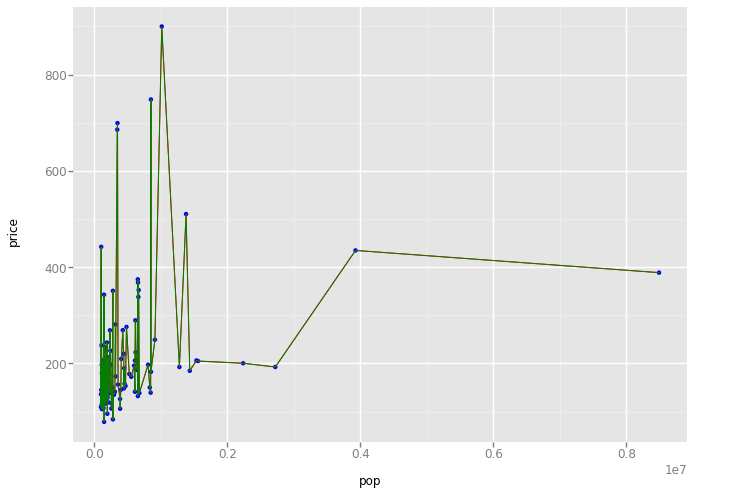

<ggplot: (-9223363269766992808)>


([Row(prediction=199.3167659584664),
  Row(prediction=198.40882267887193),
  Row(prediction=198.65258131548592),
  Row(prediction=198.87203590444247),
  Row(prediction=249.39183544694856),
  Row(prediction=211.25050693302884),
  Row(prediction=198.7671467407576),
  Row(prediction=204.4100325554172),
  Row(prediction=339.79707185649573),
  Row(prediction=203.37085497805194),
  Row(prediction=209.63377749220228),
  Row(prediction=243.49577931936597),
  Row(prediction=223.51581105852597),
  Row(prediction=229.6888123761335),
  Row(prediction=195.26728828229332),
  Row(prediction=208.14571209216254),
  Row(prediction=216.3868631323583),
  Row(prediction=196.87369889728708),
  Row(prediction=196.00786247475386),
  Row(prediction=196.21866134533786),
  Row(prediction=216.1990453830429),
  Row(prediction=197.71439971843276),
  Row(prediction=196.14979357732565),
  Row(prediction=223.55032053832574),
  Row(prediction=195.16273929967986),
  Row(prediction=207.55992028719376),
  Row(prediction=1

In [17]:
Linear_regression_ggplot()

In [18]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml.classification import LinearSVC
from pyspark.ml.feature import VectorAssembler

def Linear_svm():
    

    spark = SparkSession\
        .builder\
        .appName("Python Spark ML example")\
        .getOrCreate()
# Loads data.
    dataset= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")
    dataset.toPandas()

#creating feature vectors
    workclass_stringIndexer = StringIndexer(inputCol="workclass", outputCol="workclass_indexed")
    si_model_workclass = workclass_stringIndexer.fit(dataset)
    education_stringIndexer = StringIndexer(inputCol="education", outputCol="education_indexed")
    si_model_education = education_stringIndexer.fit(dataset)
    occupation_stringIndexer = StringIndexer(inputCol="occupation", outputCol="occupation_indexed")
    si_model_occupation = occupation_stringIndexer.fit(dataset)
    sex_stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
    si_model_sex = sex_stringIndexer.fit(dataset)
    income_stringIndexer = StringIndexer(inputCol="income", outputCol="income_indexed")
    si_model_income = income_stringIndexer.fit(dataset)
    td = si_model_workclass.transform(si_model_education.transform(si_model_occupation.transform(si_model_sex.transform(si_model_income.transform(dataset)))))
    td.toPandas()


#feature_columns = ["age","workclass_indexed","fnlwgt","education_num","hours_per_week","sex_indexed","education_indexed","occupation_indexed","income_indexed"]
    feature_columns = ["age","sex_indexed"]
    feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

    td_dataset_prepared = feature_assembler.transform(td)
    td_dataset_prepared.printSchema()
    td_dataset_prepared.toPandas()

    (trainingData, testData) = td_dataset_prepared.randomSplit([0.8,0.2])


#initialises the svmmodel
    svm = LinearSVC(maxIter=5, regParam=0.04,labelCol="income_indexed")

#trainms the svm with training data
    model = svm.fit(trainingData)

#provides coefficients for w and b
    model.coefficients

    model.numFeatures


    model.numClasses

#tests on a test dataset
    
    
    return model.transform(testData).toPandas()


In [19]:
Linear_svm()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- income_indexed: double (nullable = true)
 |-- sex_indexed: double (nullable = true)
 |-- occupation_indexed: double (nullable = true)
 |-- education_indexed: double (nullable = true)
 |-- workclass_indexed: double (nullable = true)
 |-- features: vector (nullable = true)



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,native_country,income,income_indexed,sex_indexed,occupation_indexed,education_indexed,workclass_indexed,features,rawPrediction,prediction
0,17,?,80077.0,11th,7.0,Never-married,?,Own-child,White,Female,...,United-States,<=50K,0.0,1.0,7.0,5.0,3.0,"[17.0, 1.0]","[0.8555816323609309, -0.8555816323609309]",0.0
1,17,?,89870.0,10th,6.0,Never-married,?,Own-child,White,Male,...,United-States,<=50K,0.0,0.0,7.0,7.0,3.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0
2,17,?,138507.0,10th,6.0,Never-married,?,Own-child,White,Male,...,United-States,<=50K,0.0,0.0,7.0,7.0,3.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0
3,17,?,145886.0,11th,7.0,Never-married,?,Own-child,White,Female,...,United-States,<=50K,0.0,1.0,7.0,5.0,3.0,"[17.0, 1.0]","[0.8555816323609309, -0.8555816323609309]",0.0
4,17,?,202521.0,11th,7.0,Never-married,?,Own-child,White,Male,...,United-States,<=50K,0.0,0.0,7.0,5.0,3.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0
5,17,Private,65368.0,11th,7.0,Never-married,Sales,Own-child,White,Female,...,United-States,<=50K,0.0,1.0,3.0,5.0,0.0,"[17.0, 1.0]","[0.8555816323609309, -0.8555816323609309]",0.0
6,17,Private,100828.0,11th,7.0,Never-married,Other-service,Not-in-family,White,Male,...,United-States,<=50K,0.0,0.0,4.0,5.0,0.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0
7,17,Private,123335.0,10th,6.0,Never-married,Sales,Own-child,White,Female,...,United-States,<=50K,0.0,1.0,3.0,7.0,0.0,"[17.0, 1.0]","[0.8555816323609309, -0.8555816323609309]",0.0
8,17,Private,160968.0,11th,7.0,Never-married,Adm-clerical,Own-child,White,Male,...,United-States,<=50K,0.0,0.0,5.0,5.0,0.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0
9,17,Private,175024.0,11th,7.0,Never-married,Handlers-cleaners,Own-child,White,Male,...,United-States,<=50K,0.0,0.0,9.0,5.0,0.0,"[17.0, 0.0]","[0.5197123407543731, -0.5197123407543731]",0.0


In [20]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from operator import add
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def Binomial_logitRegression():
    

    spark = SparkSession \
        .builder \
        .appName("Logistic regression with binomial") \
        .getOrCreate()
	
#creating dataframe	
    ad_data= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")
    ad_data.createOrReplaceTempView("adult")
    dataset = spark.table("adult")
    cols = dataset.columns
####### if you would like to check how the dataframe looks like and it's columns ######

#ad_data.createOrReplaceTempView("adult")
#dataset = spark.table("adult")
#cols = dataset.columns
#print cols

############# Columns ##################


    categoricalColumns = ["workclass"]
# workclass ---> Index ---> workclassIndex
    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
        encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
    # onehotencoder will take n-1 distinct values and convert to vector
        stages += [stringIndexer, encoder]

    print(stages)



# Convert label into label indices using the StringIndexer
# means in our example we have <50k and >=50k so <50k will get label 0.0 and >50k will get label 1.0
    label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")
    stages += [label_stringIdx]
# Transform all features into a vector using VectorAssembler
    numericCols = ["age","hours_per_week"]
    assemblerInputs = list(map(lambda c: c + "classVec", categoricalColumns)) + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]

    print(stages)
    print(assembler)

# Create a Pipeline.
    pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(dataset)
    dataset = pipelineModel.transform(dataset)
    dataset.printSchema()
    dataset.show(10,truncate=False)

# Keep relevant columns
#selectedcols = ["label", "features"] # we can add other columns if required by just giving below line
    selectedcols = ["label", "features"] + cols
    dataset = dataset.select(selectedcols)

# we can use print dataset
### Randomly split data into training and test sets. set seed for reproducibility
    (trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

### so if we have 100 records then 70 will be in training and 30 will be in testing (approximately)

# Create initial LogisticRegression model

    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10,family="binomial")

#### we can pass either binomial or multinomial
#### here maxIter represents the no of times the logistic regression logic try finding best fit

# Train model with Training Data
    lrModel = lr.fit(trainingData)
######################### difference between multiclass/binary is coefficients ########################
    print(lrModel.coefficients)

############################################################################################################

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
    predictions = lrModel.transform(testData)

    predictions.printSchema()

# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose income & occupation
    selected = predictions.select("label", "prediction", "probability", "income")

    selected.printSchema()

    selected.show(truncate=False)

#binary classification

# Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

    print(evaluator.evaluate(predictions))
    
    return evaluator.getMetricName()

    


In [21]:
Binomial_logitRegression()

[StringIndexer_4f4d9cabb684144f2e1b, OneHotEncoder_449a92dc74c602eb5034]
[StringIndexer_4f4d9cabb684144f2e1b, OneHotEncoder_449a92dc74c602eb5034, StringIndexer_464ba98e40e93c486f30, VectorAssembler_4be4ab56117e9594e7af]
VectorAssembler_4be4ab56117e9594e7af
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = true)
 |-- workclassclassVec: vector (nullable = true)
 |-- label: double (n

'areaUnderROC'

In [22]:
from pyspark.mllib.feature import Word2Vec
from pyspark.sql import SparkSession

def Word2vec():
    

    spark = SparkSession \
        .builder \
        .appName("Python Spark ML example") \
        .getOrCreate()
        

    sc = spark.sparkContext





    dataset = sc.textFile("/home/raj/Downloads/notenook/skillset.txt").map(lambda row: row.split(" "))

    word2vec = Word2Vec()
    model = word2vec.fit(dataset)

    synonyms = model.findSynonyms('html', 5)

    for word, cosine_distance in synonyms:
        print("{}: {}".format(word, cosine_distance))
        
        return word, cosine_distance

In [23]:
Word2vec()

bootstrap,: 0.9385954141616821


('bootstrap,', 0.9385954141616821)

In [24]:
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

def Multinomial_LogitRegression():
    

    spark = SparkSession \
        .builder \
        .appName("Logistic regression with multinomial") \
        .getOrCreate()
    
    

    


#creating dataframe	
    ad_data= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")
    ad_data.createOrReplaceTempView("adult")
    dataset = spark.table("adult")
    cols = dataset.columns
#print cols

####### if you would like to check how the dataframe looks like and it's columns ######

#ad_data.createOrReplaceTempView("adult")
#dataset = spark.table("adult")
#cols = dataset.columns
#print cols

############# Columns ##################

    categoricalColumns = ["workclass"]
    stages = []
    for categoricalCol in categoricalColumns:
        stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol+"Index")
	#In the above line for example, it takes workclass string and concatinates with the address("Index")
        encoder = OneHotEncoder(inputCol=categoricalCol+"Index", outputCol=categoricalCol+"classVec")
    # onehotencoder will take n-1 distinct values and convert to vector
        stages += [stringIndexer, encoder]
    print(stages)


# Convert label into label indices using the StringIndexer
# means in our example we have <50k , >=50k, and =50k. so <50k will get label 0.0 and >50k will get label 1.0
#, and =50 will get 2.0
    label_stringIdx = StringIndexer(inputCol = "income", outputCol = "label")
    stages += [label_stringIdx]
# Transform all features into a vector using VectorAssembler
    numericCols = ["age","hours_per_week"]
    assemblerInputs = list(map(lambda c: c + "classVec", categoricalColumns)) + numericCols
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
    stages += [assembler]



# Create a Pipeline.
    pipeline = Pipeline(stages=stages)
# Run the feature transformations.
#  - fit() computes feature statistics as needed.
#  - transform() actually transforms the features.
    pipelineModel = pipeline.fit(dataset)
    dataset = pipelineModel.transform(dataset)

#print schema
    dataset.printSchema()

# Keep relevant columns
    selectedcols = ["label", "features"] + cols
    dataset = dataset.select(selectedcols)

# we can use print dataset
### Randomly split data into training and test sets. set seed for reproducibility
    (trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

### if you want to check the count then use below code
    print(trainingData.count())
    print(testData.count())
    testData.show(truncate=False)


### so if we have 100 records then 70 will be in training and 30 will be in testing (approximately)

# Create initial LogisticRegression model and passing multinomial family
    lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10,family="multinomial")
#### here maxIter represents the no of times the logistic regression logic try finding best fit

# Train model with Training Data
    lrModel = lr.fit(trainingData)
######################### difference between multiclass/binary is coefficientMatrix ########################
#print lrModel.coefficientMatrix

############################################################################################################

# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
    predictions = lrModel.transform(testData)

#predictions.printSchema()

# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose income & occupation
    selected = predictions.select("label", "prediction", "probability", "income")
#selected.printSchema()
    selected.show(truncate=False)


#binary classification

# Evaluate model
    evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction") 
    print("evaluation")
    print(evaluator.evaluate(predictions))

    
    
    return evaluator.getMetricName()

#areaUnderROC  : Computes the area under the receiver operating characteristic (ROC) curve.
#areaUnderPR area under the precision-recall curve (precision as a function of recall)

#lr.explainParams()


In [25]:
Multinomial_LogitRegression()

[StringIndexer_42a88f35df67bed1524a, OneHotEncoder_457cbd06dc7f18da911b]
root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)
 |-- workclassIndex: double (nullable = true)
 |-- workclassclassVec: vector (nullable = true)
 |-- label: double (nullable = true)
 |-- features: vector (nullable = true)

2103
896
+-----+---------------------------+---+---------+--------+-------------+-------------+--------------+-----------------

'areaUnderROC'

In [26]:


# import modules 
#converting pyspark sql dataframe into labeled Rdd Dataframe
from pyspark.mllib.regression import LabeledPoint
from pyspark.sql.functions import col
from pyspark.mllib import linalg as mllib_linalg
from pyspark.ml import linalg as ml_linalg
from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler

# import naive bayes model module
from pyspark.mllib.classification import NaiveBayes , NaiveBayesModel

def Naive_bayes():
    
#create sparksession
    spark = SparkSession \
        .builder \
        .appName("naive_bayes") \
        .getOrCreate()
	
#creating dataframe	
    ad_data= spark\
    .read\
    .option("inferSchema", "true")\
    .option("header", "true")\
    .csv("/home/raj/Downloads/notenook/adult2.csv")

    cols = ad_data.columns

# dependent variable on which our model will predict
    categoricalcolumns = ["workclass"]

# convert raw features to numberic features and one hot encoding for features representation 

    stages = []
    for categoricalcol in categoricalcolumns:
        stringindexer = StringIndexer(inputCol=categoricalcol , outputCol=categoricalcol+"index")
        encoder = OneHotEncoder(inputCol=categoricalcol+"index" , outputCol=categoricalcol+"classvec")
        stages += [stringindexer , encoder]
    print(stages)

#convert string features into numeric features
    label_stringidx = StringIndexer(inputCol= "income" , outputCol= "label")


    stages += [label_stringidx]


    numeric_cols = ['age' , 'hours_per_week']

#transforming all feature vector into single vector 
    assemblerinputs  = list(map(lambda c: c + "classvec" , categoricalcolumns)) + numeric_cols


    assembler = VectorAssembler(inputCols=assemblerinputs , outputCol="features")


    stages += [assembler]


    print(stages)
    print(assembler)


#creating pipeline and Transforming the data
    pipline = Pipeline(stages=stages)

    piplinemodel = pipline.fit(ad_data)


    dataset = piplinemodel.transform(ad_data)

    dataset.printSchema

# keep relevant col.
#selectedcols =  ["label" , "features"] + cols

    selectedcols =  ["label" , "features"]
    dataset = dataset.select(selectedcols)

    trainingData, testData = dataset.randomSplit([0.7, 0.3], seed = 100)
#trainingData.show()



    def as_old(v):
        if isinstance(v, ml_linalg.SparseVector):
            return mllib_linalg.SparseVector(v.size, v.indices, v.values)
        if isinstance(v, ml_linalg.DenseVector):
            return mllib_linalg.DenseVector(v.values)
        raise ValueError("Unsupported type {0}".format(type(v)))
    
#mapping sql dataframe to Rdd_dataframe
    trainingDataRdd=trainingData.rdd.map(lambda p:LabeledPoint(p.label,as_old(p.features)))
    testDataRdd=testData.rdd.map(lambda p:LabeledPoint(p.label,as_old(p.features)))

# model training
    model = NaiveBayes.train(trainingDataRdd, 1.0)


#model prediction and 
    predictionAndLabel = testDataRdd.map(lambda p: (model.predict(p.features), p.label))
    accuracy = 1.0 * predictionAndLabel.filter(lambda pl: pl[0] == pl[1]).count() / testDataRdd.count()
    print('model accuracy {}'.format(accuracy))
    
    return accuracy



In [27]:
Naive_bayes()

[StringIndexer_4aeba104b2974b1db6cc, OneHotEncoder_4329bfbd84d9f2cf7edd]
[StringIndexer_4aeba104b2974b1db6cc, OneHotEncoder_4329bfbd84d9f2cf7edd, StringIndexer_4cd7bbd4492e22201c18, VectorAssembler_41fd9f22ad406e177385]
VectorAssembler_41fd9f22ad406e177385
model accuracy 0.7723214285714286


0.7723214285714286

In [28]:
# import necessary module
from pyspark.ml import Pipeline
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import VectorIndexer,StringIndexer
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

def Random_forest():
    
        spark = SparkSession\
            .builder\
            .appName("RandomForestRegressionExample")\
            .getOrCreate()

    
        
    # Load the data, filetype and path
        dataset = spark.read.format("csv").option("inferSchema","true").option("header","true").load("/home/raj/Downloads/notenook/adult2.csv")

#converts data into feature vectors
        dataset.printSchema()
        workclass_stringIndexer = StringIndexer(inputCol="workclass", outputCol="workclass_indexed")
        si_model_workclass = workclass_stringIndexer.fit(dataset)
        education_stringIndexer = StringIndexer(inputCol="education", outputCol="education_indexed")
        si_model_education = education_stringIndexer.fit(dataset)
        occupation_stringIndexer = StringIndexer(inputCol="occupation", outputCol="occupation_indexed")
        si_model_occupation = occupation_stringIndexer.fit(dataset)
        sex_stringIndexer = StringIndexer(inputCol="sex", outputCol="sex_indexed")
        si_model_sex = sex_stringIndexer.fit(dataset)
        income_stringIndexer = StringIndexer(inputCol="income", outputCol="income_indexed")
        si_model_income = income_stringIndexer.fit(dataset)
        td = si_model_workclass.transform(si_model_education.transform(si_model_occupation.transform(si_model_sex.transform(si_model_income.transform(dataset)))))




        feature_columns = ["age","sex_indexed"]

        feature_assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
        data = feature_assembler.transform(td)




    # Load and parse the data file into an RDD of LabeledPoint.

    # Split the data into training and test sets (30% held out for testing)
        (trainingData, testData) = data.randomSplit([0.7, 0.3])

    # Train a RandomForest model.
    #  Empty categoricalFeaturesInfo indicates all features are continuous.
    #  Note: Use larger numTrees in practice.
    #  Setting featureSubsetStrategy="auto" lets the algorithm choose.
        rf = RandomForestRegressor(numTrees=2, maxDepth=2, seed=42,labelCol="income_indexed")
        model = rf.fit(trainingData)
    # Evaluate model on test instances and compute test error
   

#Estimate of the importance of each feature
        model.featureImportances

#Transforms the input dataset into our model
    
        return model.transform(testData).toPandas()

In [29]:
Random_forest()

root
 |-- age: integer (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: double (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- native_country: string (nullable = true)
 |-- income: string (nullable = true)



,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,...,hours_per_week,native_country,income,income_indexed,sex_indexed,occupation_indexed,education_indexed,workclass_indexed,features,prediction
0,17,?,64785.0,10th,6.0,Never-married,?,Own-child,White,Male,...,30.0,United-States,<=50K,0.0,0.0,7.0,7.0,3.0,"[17.0, 0.0]",0.044915
1,17,?,138507.0,10th,6.0,Never-married,?,Own-child,White,Male,...,20.0,United-States,<=50K,0.0,0.0,7.0,7.0,3.0,"[17.0, 0.0]",0.044915
2,17,?,145886.0,11th,7.0,Never-married,?,Own-child,White,Female,...,30.0,United-States,<=50K,0.0,1.0,7.0,5.0,3.0,"[17.0, 1.0]",0.029165
3,17,Private,102726.0,12th,8.0,Never-married,Other-service,Own-child,White,Male,...,16.0,United-States,<=50K,0.0,0.0,4.0,12.0,0.0,"[17.0, 0.0]",0.044915
4,17,Private,122041.0,11th,7.0,Never-married,Craft-repair,Own-child,White,Male,...,20.0,United-States,<=50K,0.0,0.0,2.0,5.0,0.0,"[17.0, 0.0]",0.044915
5,17,Private,123335.0,10th,6.0,Never-married,Sales,Own-child,White,Female,...,20.0,United-States,<=50K,0.0,1.0,3.0,7.0,0.0,"[17.0, 1.0]",0.029165
6,17,Private,130806.0,10th,6.0,Never-married,Handlers-cleaners,Own-child,White,Male,...,24.0,United-States,<=50K,0.0,0.0,9.0,7.0,0.0,"[17.0, 0.0]",0.044915
7,17,Private,191260.0,9th,5.0,Never-married,Other-service,Own-child,White,Male,...,24.0,United-States,<=50K,0.0,0.0,4.0,8.0,0.0,"[17.0, 0.0]",0.044915
8,17,Private,245918.0,11th,7.0,Never-married,Other-service,Own-child,White,Male,...,12.0,United-States,<=50K,0.0,0.0,4.0,5.0,0.0,"[17.0, 0.0]",0.044915
9,17,Private,368700.0,11th,7.0,Never-married,Sales,Own-child,White,Male,...,28.0,United-States,<=50K,0.0,0.0,3.0,5.0,0.0,"[17.0, 0.0]",0.044915
